In [137]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/wtb2/Documents/EBTEL_analysis/src/')
import ebtel_dem as ebd
import ebtel_plot_em as ebpe
from imp import reload
reload(ebd)
reload(ebpe)

<module 'ebtel_plot_em' from '/home/wtb2/Documents/EBTEL_analysis/src/ebtel_plot_em.py'>

#Emission Measure Slope Limits Testing

To get an accurate measure of the hotward slope in our plots of $\mathrm{EM}(T)$ generated by EBTEL, need to choose the limits over which the slope is calculated carefully.

First, we'll load in the data we need ($L=40$ Mm, $\alpha=-1.5$, electron heating) and then run statistics on our slope calculations.

In [138]:
loop_length = 40.0
alpha = 1.5
tpulse = 100.0
solver = 'rka4'
tn = np.arange(250,5250,250)
root_dir = '/data/datadrive2/EBTEL-2fluid_runs/'
species = 'electron'

First, we'll use the default values for the slope limits and see what those look like.

In [139]:
slope_limits = {'cool_lower':6.0,'cool_upper':6.6,
               'hot_lower':6.8,'hot_upper':7.25}
t_cool,t_hot = [],[]
[t_cool.append(np.linspace(slope_limits['cool_lower'],slope_limits['cool_upper'],1000)) for i in range(len(tn))]
[t_hot.append(np.linspace(slope_limits['hot_lower'],slope_limits['hot_upper'],1000)) for i in range(len(tn))]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [140]:
#load in the data
dema = ebd.DEMAnalyzer(root_dir,species,alpha,loop_length,tpulse,solver,Tn=tn,verbose=False,slope_limits=slope_limits)
dema.process_raw()
dema.em_statistics()

In [141]:
#process slope data
dema.many_slopes()
dema.slope_statistics()

Now, let's plot the resulting emission measure curves with the fit lines overlaid to assess the fit.

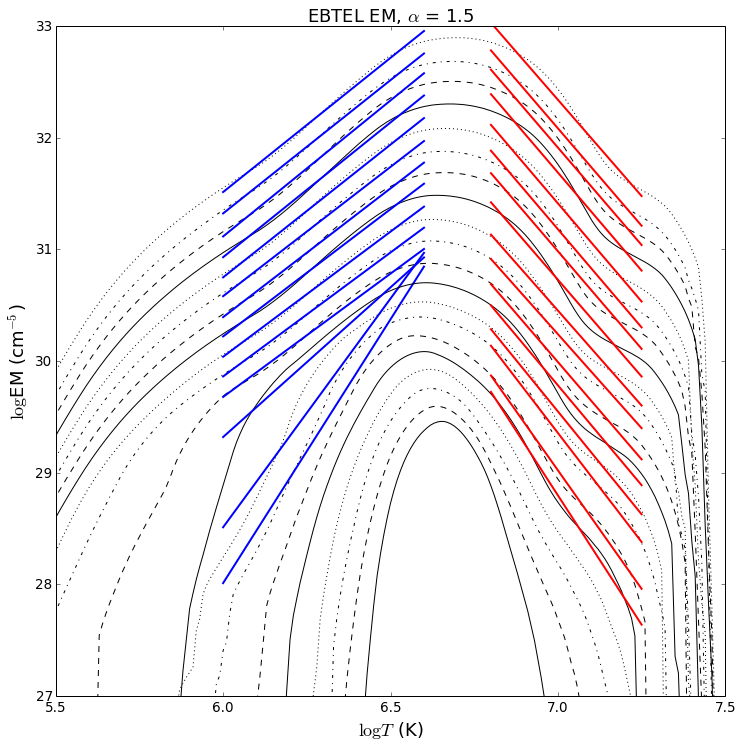

In [142]:
demp = ebpe.DEMPlotter(dema.temp_em,dema.em,alpha,Tn=tn)
fit_lines = {'t_cool':t_cool,'a_cool':dema.a_cool_mean,'b_cool':dema.b_cool_mean,
             't_hot':t_hot,'a_hot':dema.a_hot_mean,'b_hot':dema.b_hot_mean}
demp.plot_em_curves(dema.temp_mean,dema.em_mean,fit_lines=fit_lines)

In [143]:
temporary = np.array(dema.em_mean[-1])[np.where(np.isinf(dema.em_mean[-1]) == False)]
temporary_temp = np.array(dema.temp_mean[-1])[np.where(np.isinf(dema.em_mean[-1]) == False)]

(-2, 2)

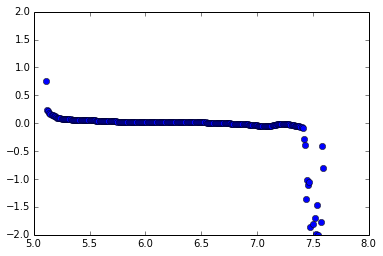

In [144]:
plt.plot(temporary_temp[:-1],np.diff(temporary),'o')
plt.ylim([-2,2])

Let's try just shifting the hot slope limits upward a little bit and see if this makes a significant difference.

In [145]:
slope_limits = {'cool_lower':6.0,'cool_upper':6.6,
               'hot_lower':6.9,'hot_upper':7.3}
t_cool,t_hot = [],[]
[t_cool.append(np.linspace(slope_limits['cool_lower'],slope_limits['cool_upper'],1000)) for i in range(len(tn))]
[t_hot.append(np.linspace(slope_limits['hot_lower'],slope_limits['hot_upper'],1000)) for i in range(len(tn))]
dema.slope_limits = slope_limits

In [146]:
#process slope data
dema.many_slopes()
dema.slope_statistics()

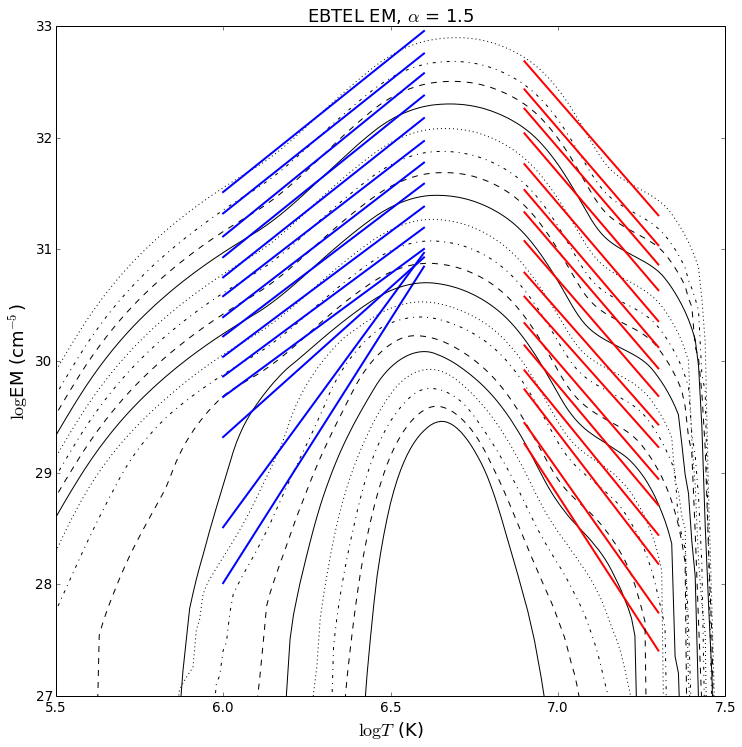

In [147]:
demp = ebpe.DEMPlotter(dema.temp_em,dema.em,alpha,Tn=tn)
fit_lines = {'t_cool':t_cool,'a_cool':dema.a_cool_mean,'b_cool':dema.b_cool_mean,
             't_hot':t_hot,'a_hot':dema.a_hot_mean,'b_hot':dema.b_hot_mean}
demp.plot_em_curves(dema.temp_mean,dema.em_mean,fit_lines=fit_lines)

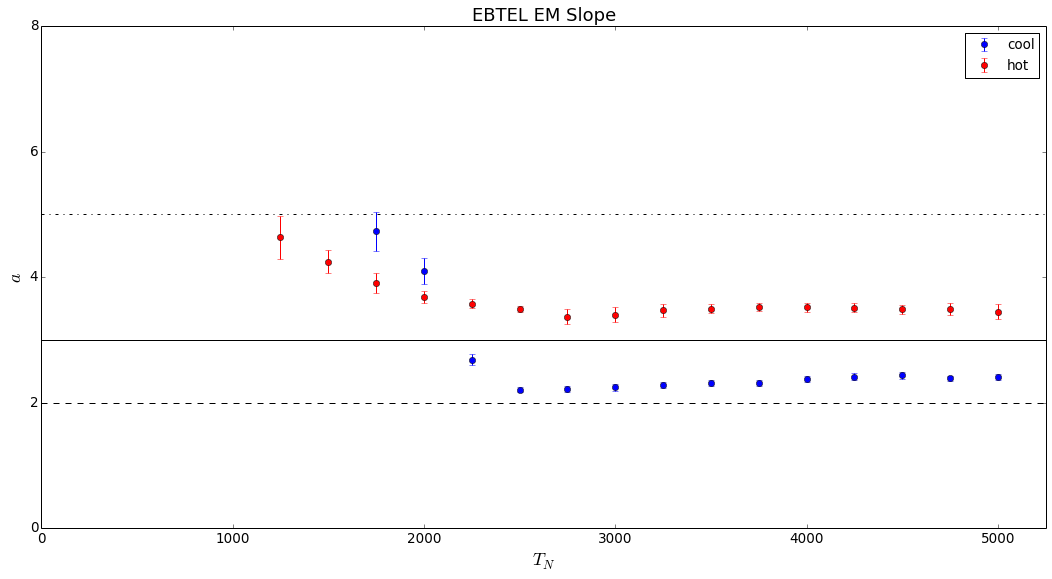

In [148]:
demp.figsize = (18,9)
demp.plot_em_slopes(dema.a_cool_mean,dema.a_cool_std,dema.a_hot_mean,dema.a_hot_std)

But what would this look like for the single-species case? Limits may be too far to the right.

In [149]:
root_dir = '/data/datadrive2/EBTEL_C_runs/'
species = 'single'

In [150]:
#load in the data
dema_single = ebd.DEMAnalyzer(root_dir,species,alpha,loop_length,tpulse,solver,Tn=tn,verbose=False,slope_limits=slope_limits)
dema_single.process_raw()
dema_single.em_statistics()

In [151]:
#process slope data
dema_single.many_slopes()
dema_single.slope_statistics()

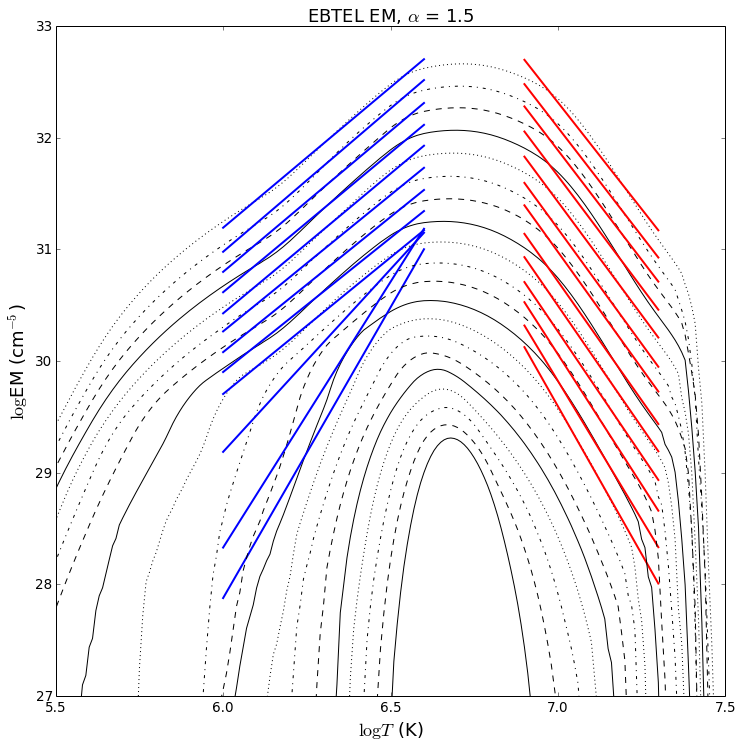

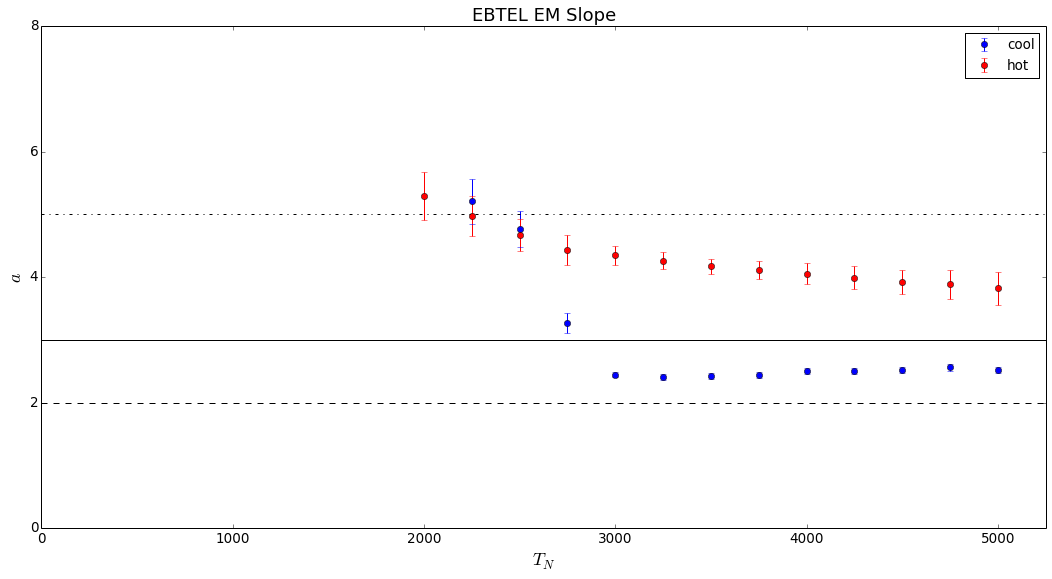

In [152]:
demp_single = ebpe.DEMPlotter(dema_single.temp_em,dema_single.em,alpha,Tn=tn)
fit_lines = {'t_cool':t_cool,'a_cool':dema_single.a_cool_mean,'b_cool':dema_single.b_cool_mean,
             't_hot':t_hot,'a_hot':dema_single.a_hot_mean,'b_hot':dema_single.b_hot_mean}
demp_single.plot_em_curves(dema_single.temp_mean,dema_single.em_mean,fit_lines=fit_lines)
demp_single.figsize = (18,9)
demp_single.plot_em_slopes(dema_single.a_cool_mean,dema_single.a_cool_std,dema_single.a_hot_mean,dema_single.a_hot_std)

So using $6.9\leq\log(T)\leq7.3$ seems to work alright though the fits are still a little off in the single-species EBTEL-C case, giving a shallower slope than the hot shoulder actually has. 

We need to come up with a way where the limits are slightly altered for each value of $T_N$ such that the upper limit on the hot branch is the temperature at which $|\Delta(\mathrm{EM})|\geq\epsilon$, where $\epsilon$ is the threshold dropoff in $\mathrm{EM}$. The lower limit will then just be the upper limit $-0.4$.

In [153]:
def calc_upper_hot_lim(mean_temp,mean_em,delta_thresh,delta_t,alpha):
    ninf_i = np.where(np.isinf(mean_em) == False) #find non-inf indices
    max_i = np.argmax(mean_em) #find index corresponding to max value
    hot_i = ninf_i[0][np.where(ninf_i[0]>max_i)] #indices for hot branch
    em_hot = mean_em[hot_i] #hot branch em
    delta_em_hot = np.fabs(np.diff(em_hot)) #delta(em) of hot branch
    delta_i = np.where(delta_em_hot>delta_thresh)[0][0]
    lim_i = hot_i[delta_i - 1]-1
    t_upper = mean_temp[lim_i]
    t_lower = t_upper - delta_t
    return t_lower,t_upper

Now, let's apply this to one of the $(\bar{T},\overline{\mathrm{EM}})$ data set.

In [154]:
for i in range(len(dema_single.temp_mean)):
    l,u = calc_upper_hot_lim(dema_single.temp_mean[i],dema_single.em_mean[i],0.5,0.4,alpha)
    print("The lower limit is %.3f and the upper limit is %.3f"%(l,u))

The lower limit is 6.510 and the upper limit is 6.910
The lower limit is 6.580 and the upper limit is 6.980
The lower limit is 6.650 and the upper limit is 7.050
The lower limit is 6.700 and the upper limit is 7.100
The lower limit is 6.750 and the upper limit is 7.150
The lower limit is 6.780 and the upper limit is 7.180
The lower limit is 6.810 and the upper limit is 7.210
The lower limit is 6.840 and the upper limit is 7.240
The lower limit is 6.880 and the upper limit is 7.280
The lower limit is 6.880 and the upper limit is 7.280
The lower limit is 6.930 and the upper limit is 7.330
The lower limit is 6.930 and the upper limit is 7.330
The lower limit is 6.960 and the upper limit is 7.360
The lower limit is 6.970 and the upper limit is 7.370
The lower limit is 6.980 and the upper limit is 7.380
The lower limit is 6.980 and the upper limit is 7.380
The lower limit is 6.990 and the upper limit is 7.390
The lower limit is 7.000 and the upper limit is 7.400
The lower limit is 6.990 and

Now, let's apply this to the full data sets for both the electron and single-species cases.

##Electron 

First, calculate the the slope limits based on the $\overline{\mathrm{EM}}$ curves as well as the $T$ arrays needed for the final fits.

In [155]:
hot_lower_electron,hot_upper_electron = [],[]
t_cool,t_hot = [],[]
for i in range(len(dema.temp_mean)):
    l,u = calc_upper_hot_lim(dema.temp_mean[i],dema.em_mean[i],0.5,0.4,alpha)
    hot_lower_electron.append(l),hot_upper_electron.append(u)
    t_cool.append(np.linspace(slope_limits['cool_lower'],slope_limits['cool_upper'],1000))
    t_hot.append(np.linspace(l,u,1000))

Now, rerun the slope calculation and compute the slope statistics for the variable hot branch limits.

In [156]:
dema.many_slopes(slope_limits={'cool_lower':len(dema.temp_mean)*[6.0],'cool_upper':len(dema.temp_mean)*[6.6],'hot_lower':hot_lower_electron,'hot_upper':hot_upper_electron})
dema.slope_statistics()

Finally, plot the resulting $\overline{\mathrm{EM}}$ curves, fit lines, and resulting slopes.

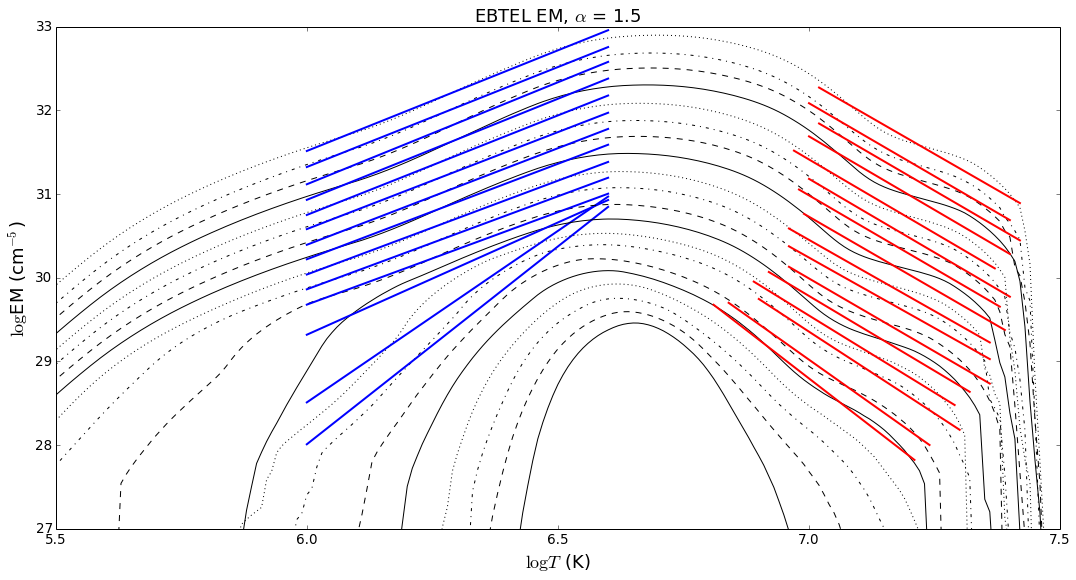

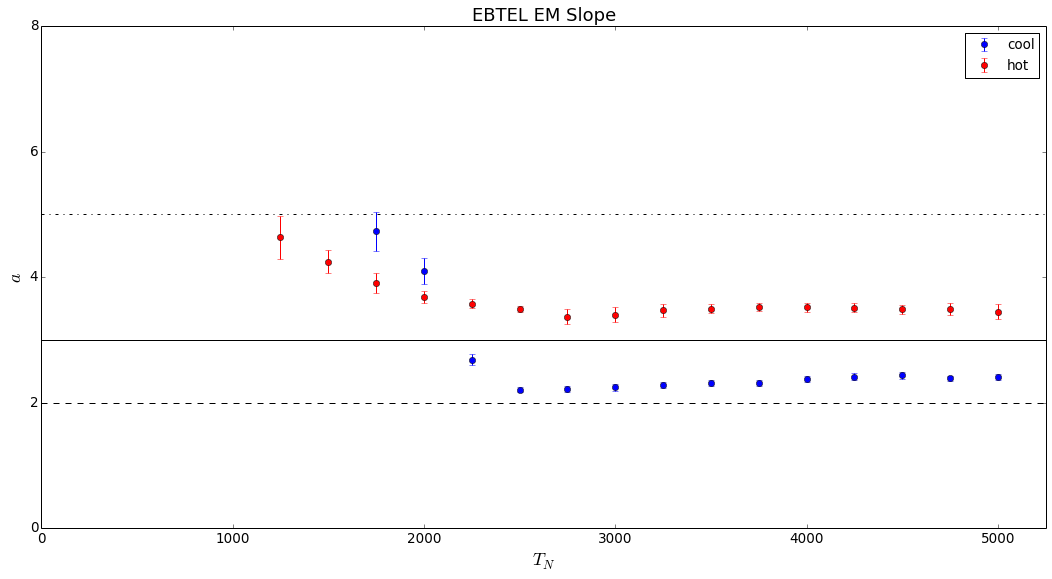

In [157]:
fit_lines = {'t_cool':t_cool,'a_cool':dema.a_cool_mean,'b_cool':dema.b_cool_mean,
             't_hot':t_hot,'a_hot':dema.a_hot_mean,'b_hot':dema.b_hot_mean}
demp.plot_em_curves(dema.temp_mean,dema.em_mean,fit_lines=fit_lines)
demp.figsize = (18,9)
demp.plot_em_slopes(dema.a_cool_mean,dema.a_cool_std,dema.a_hot_mean,dema.a_hot_std)

##Single-species

Now, do the same for the single-species case.

In [158]:
hot_lower_single,hot_upper_single = [],[]
t_cool,t_hot = [],[]
for i in range(len(dema_single.temp_mean)):
    l,u = calc_upper_hot_lim(dema_single.temp_mean[i],dema_single.em_mean[i],0.5,0.4,alpha)
    hot_lower_single.append(l),hot_upper_single.append(u)
    t_cool.append(np.linspace(slope_limits['cool_lower'],slope_limits['cool_upper'],1000))
    t_hot.append(np.linspace(l,u,1000))

In [159]:
dema_single.many_slopes(slope_limits={'cool_lower':len(dema.temp_mean)*[6.0],'cool_upper':len(dema.temp_mean)*[6.6],'hot_lower':hot_lower_single,'hot_upper':hot_upper_single})
dema_single.slope_statistics()

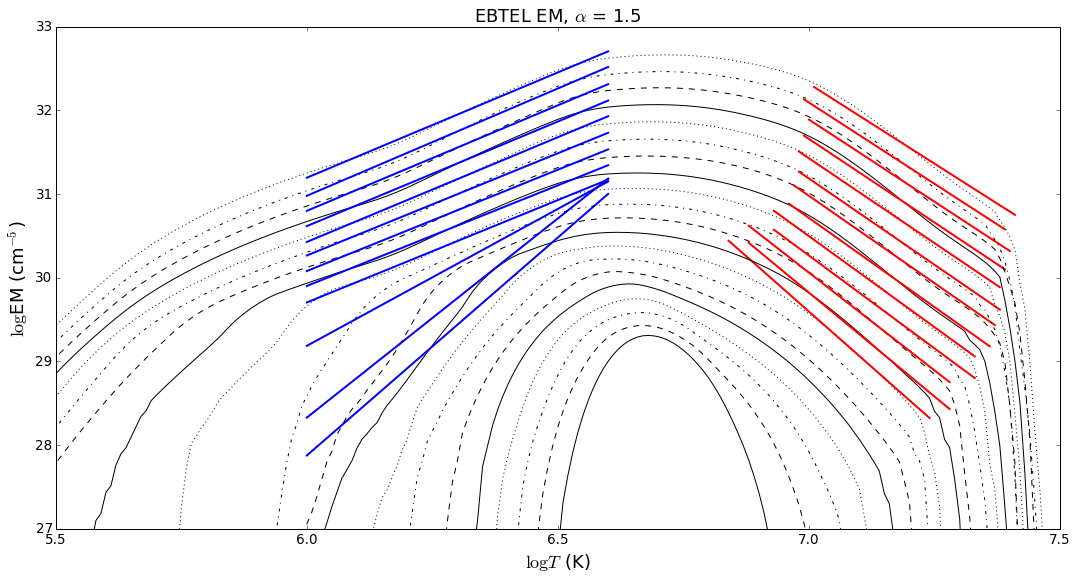

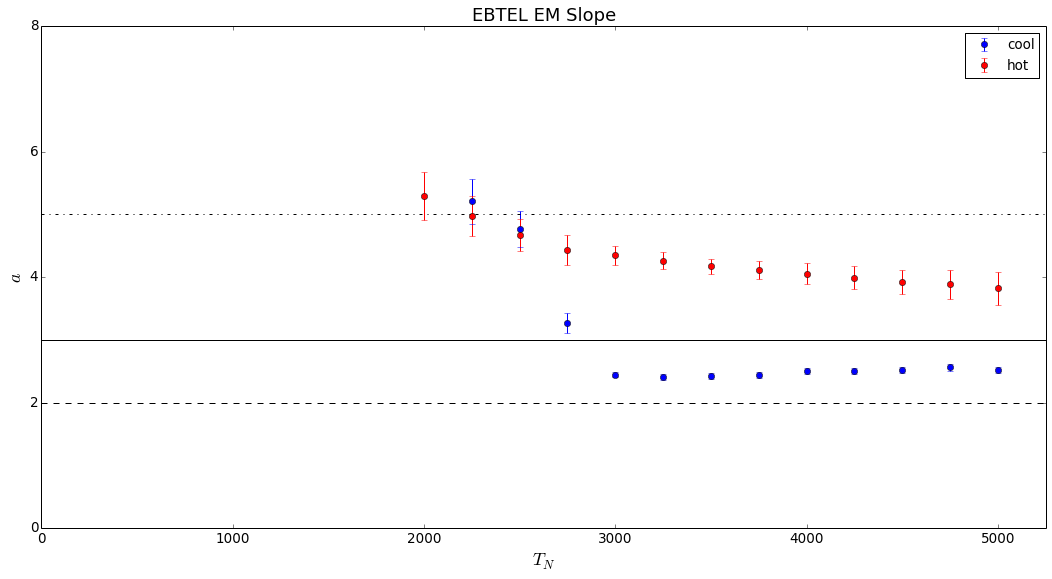

In [160]:
fit_lines = {'t_cool':t_cool,'a_cool':dema_single.a_cool_mean,'b_cool':dema_single.b_cool_mean,
             't_hot':t_hot,'a_hot':dema_single.a_hot_mean,'b_hot':dema_single.b_hot_mean}
demp_single.plot_em_curves(dema_single.temp_mean,dema_single.em_mean,fit_lines=fit_lines)
demp_single.figsize = (18,9)
demp_single.plot_em_slopes(dema_single.a_cool_mean,dema_single.a_cool_std,dema_single.a_hot_mean,dema_single.a_hot_std)

##Ion

Lastly, we'll apply our variable hot slope limits approach to the ion heating case.

In [161]:
species = 'ion'
root_dir = '/data/datadrive2/EBTEL-2fluid_runs/'

In [162]:
slope_limits = {'cool_lower':6.0,'cool_upper':6.6,
               'hot_lower':6.8,'hot_upper':7.25}
dema_ion = ebd.DEMAnalyzer(root_dir,species,alpha,loop_length,tpulse,solver,Tn=tn,verbose=False,slope_limits=slope_limits)
dema_ion.process_raw()
dema_ion.em_statistics()

In [163]:
hot_lower_ion,hot_upper_ion = [],[]
t_cool,t_hot = [],[]
for i in range(len(dema_ion.temp_mean)):
    l,u = calc_upper_hot_lim(dema_ion.temp_mean[i],dema_ion.em_mean[i],0.5,0.2,alpha)
    hot_lower_ion.append(l),hot_upper_ion.append(u)
    t_cool.append(np.linspace(slope_limits['cool_lower'],slope_limits['cool_upper'],1000))
    t_hot.append(np.linspace(hot_lower_ion[i],hot_upper_ion[i],1000))

In [164]:
dema_ion.many_slopes(slope_limits={'cool_lower':len(dema_ion.temp_mean)*[6.0],'cool_upper':len(dema_ion.temp_mean)*[6.6],'hot_lower':hot_lower_ion,'hot_upper':hot_upper_ion})
dema_ion.slope_statistics()

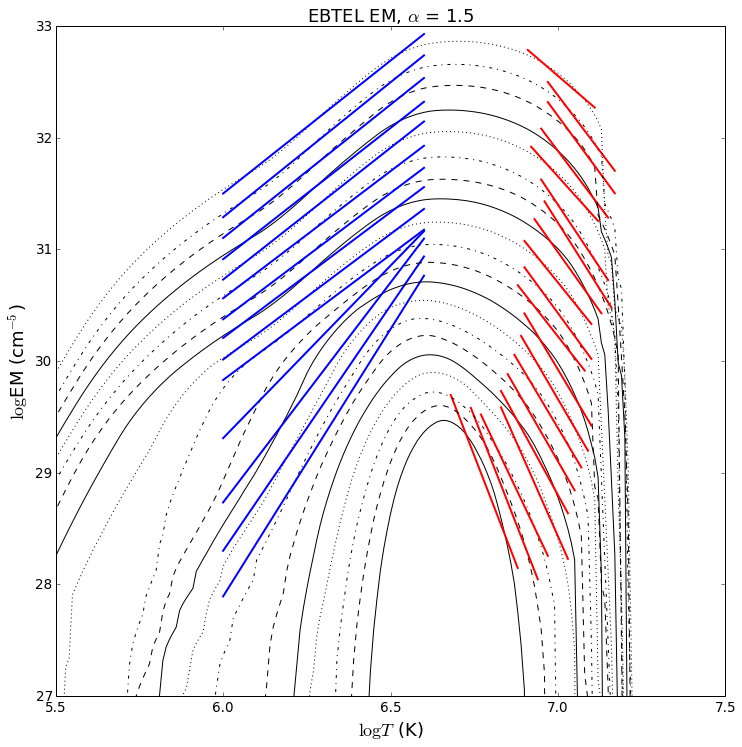

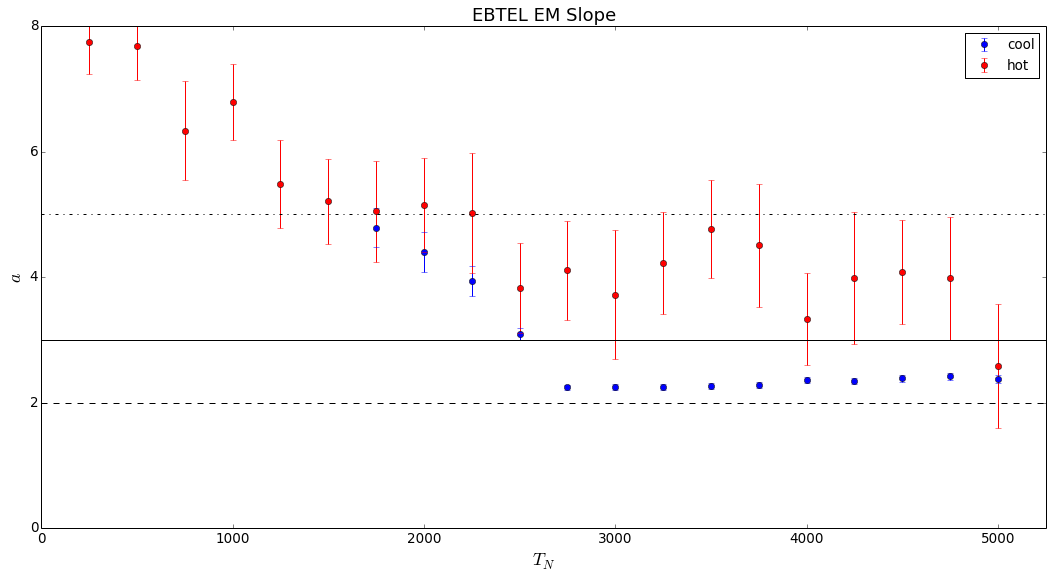

In [165]:
demp_ion = ebpe.DEMPlotter(dema_ion.temp_em,dema_ion.em,alpha,Tn=tn)
fit_lines = {'t_cool':t_cool,'a_cool':dema_ion.a_cool_mean,'b_cool':dema_ion.b_cool_mean,
             't_hot':t_hot,'a_hot':dema_ion.a_hot_mean,'b_hot':dema_ion.b_hot_mean}
demp_ion.plot_em_curves(dema_ion.temp_mean,dema_ion.em_mean,fit_lines=fit_lines)
demp_ion.figsize = (18,9)
demp_ion.plot_em_slopes(dema_ion.a_cool_mean,dema_ion.a_cool_std,dema_ion.a_hot_mean,dema_ion.a_hot_std)

##Uniform Heating

Now, we need to test a uniform heating case because of the different dimensions of our data structures in this case.

In [166]:
slope_limits = {'cool_lower':6.0,'cool_upper':6.6,
               'hot_lower':6.7,'hot_upper':7.4}
t_cool,t_hot = [],[]
[t_cool.append(np.linspace(slope_limits['cool_lower'],slope_limits['cool_upper'],1000)) for i in range(len(tn))]
[t_hot.append(np.linspace(slope_limits['hot_lower'],slope_limits['hot_upper'],1000)) for i in range(len(tn))]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [167]:
species = 'electron'
alpha = 'uniform'
solver = 'euler'
dema_uniform = ebd.DEMAnalyzer(root_dir,species,alpha,loop_length,tpulse,solver,Tn=tn,verbose=False,slope_limits=slope_limits)
dema_uniform.process_raw()
dema_uniform.em_statistics()

In [168]:
dema_uniform.many_slopes()
dema_uniform.slope_statistics()

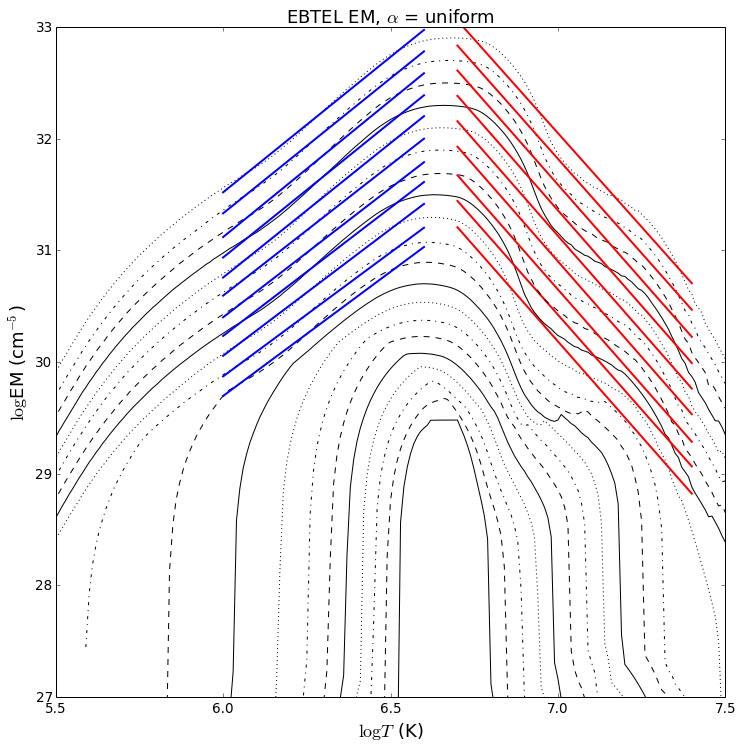

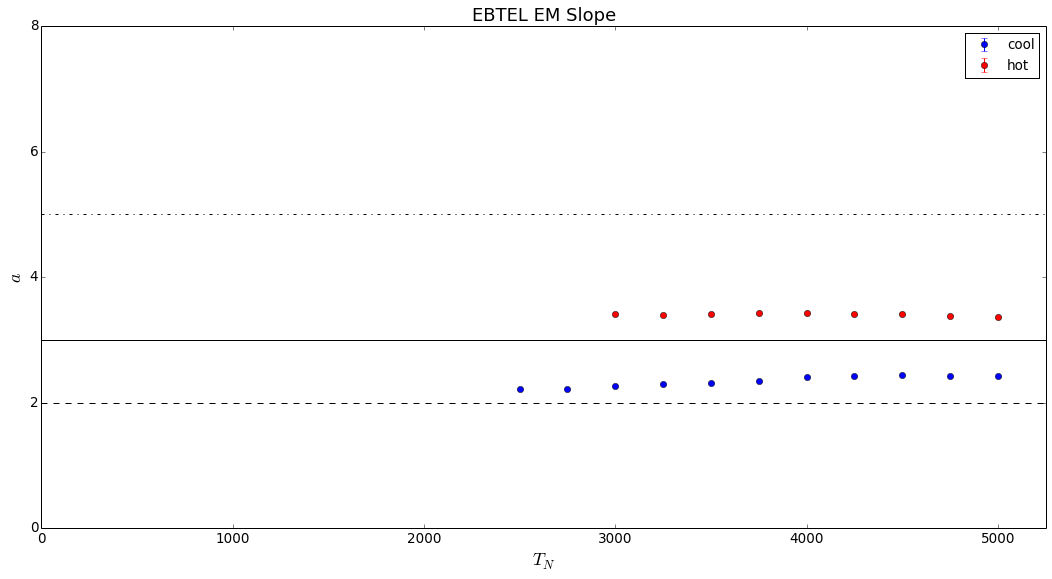

In [169]:
demp_uniform = ebpe.DEMPlotter(dema_uniform.temp_em,dema_uniform.em,alpha,Tn=tn)
fit_lines = {'t_cool':t_cool,'a_cool':dema_uniform.a_cool_mean,'b_cool':dema_uniform.b_cool_mean,
                 't_hot':t_hot,'a_hot':dema_uniform.a_hot_mean,'b_hot':dema_uniform.b_hot_mean}
demp_uniform.plot_em_curves(dema_uniform.temp_mean,dema_uniform.em_mean,fit_lines=fit_lines)
demp_uniform.figsize = (18,9)
demp_uniform.plot_em_slopes(dema_uniform.a_cool_mean,dema_uniform.a_cool_std,dema_uniform.a_hot_mean,dema_uniform.a_hot_std)

Now, what about the ion species?

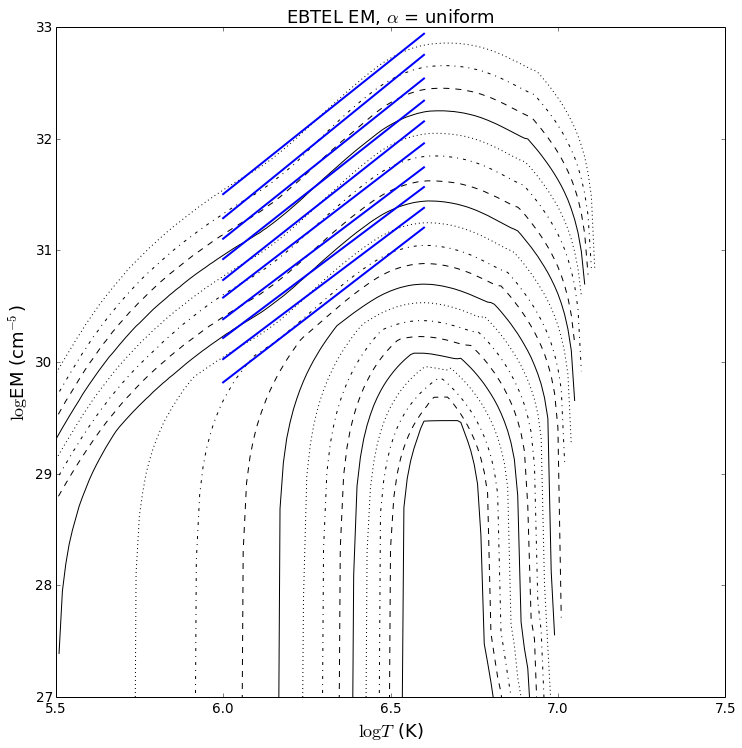

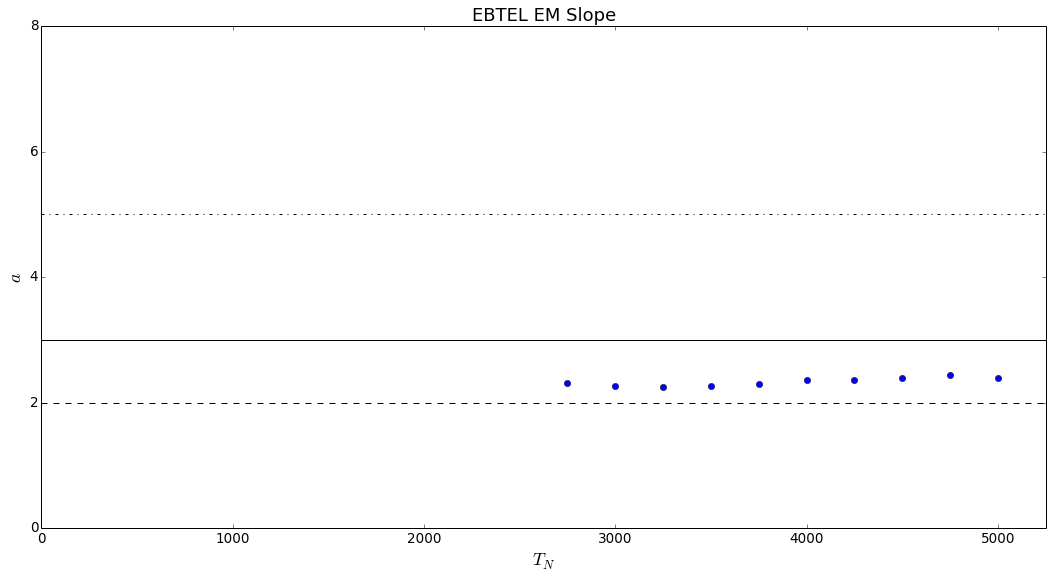

In [170]:
species = 'ion'
dema_uniform = ebd.DEMAnalyzer(root_dir,species,alpha,loop_length,tpulse,solver,Tn=tn,verbose=False,slope_limits=slope_limits)
dema_uniform.process_raw()
dema_uniform.em_statistics()
dema_uniform.many_slopes()
dema_uniform.slope_statistics()
demp_uniform = ebpe.DEMPlotter(dema_uniform.temp_em,dema_uniform.em,alpha,Tn=tn)
fit_lines = {'t_cool':t_cool,'a_cool':dema_uniform.a_cool_mean,'b_cool':dema_uniform.b_cool_mean,
                 't_hot':t_hot,'a_hot':dema_uniform.a_hot_mean,'b_hot':dema_uniform.b_hot_mean}
demp_uniform.plot_em_curves(dema_uniform.temp_mean,dema_uniform.em_mean,fit_lines=fit_lines)
demp_uniform.figsize = (18,9)
demp_uniform.plot_em_slopes(dema_uniform.a_cool_mean,dema_uniform.a_cool_std,dema_uniform.a_hot_mean,dema_uniform.a_hot_std)